In [1]:
import warnings

warnings.filterwarnings('ignore')
import numpy
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import shutil
import glob
import pandas as pd
import random
from google.colab.patches import cv2_imshow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D ,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.applications.mobilenet import MobileNet,preprocess_input
from tensorflow.keras.models import Model
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.models import load_model

from tensorflow.keras.applications.vgg16 import VGG16

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools

from google.colab import files

#shutil.rmtree('/content/Train/')

In [2]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/shiekhburhan/face-mask-dataset")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ziadzamab
Your Kaggle Key: ··········


100%|██████████| 2.33G/2.33G [00:27<00:00, 89.6MB/s]


In [57]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/faceMask.zip


In [4]:
with_mask_dir = "/content/face-mask-dataset/FMD_DATASET/with_mask/simple"
without_mask_dir = "/content/face-mask-dataset/FMD_DATASET/without_mask/simple"
mc_dir = "/content/face-mask-dataset/FMD_DATASET/incorrect_mask/mc"
mmc_dir = "/content/face-mask-dataset/FMD_DATASET/incorrect_mask/mmc"


In [5]:
def get_file_paths(path):
    file_paths = []
    for dirpath, dirnames, filenames in os.walk(path):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)
            file_paths.append(file_path)
    return file_paths

In [61]:
mask_data = get_file_paths(with_mask_dir)
no_mask_data = get_file_paths(without_mask_dir)
test_mask = get_file_paths("/content/faceMask/mask")
test_no_mask = get_file_paths("/content/faceMask/nomask")

#mc_data = get_file_paths(mc_dir)
#mmc_data = get_file_paths(mmc_dir)

In [64]:
print(f"mask data : {len(mask_data)} , no mask data : {len(no_mask_data)} , test mask : {len(test_mask)} , no mask test : {len(test_no_mask)}")


mask data : 4000 , no mask data : 4000 , test mask : 1912 , no mask test : 420


In [65]:
#no need to balance 
test_mask = mask_data[0:len(test_no_mask)]
print(len(test_mask))

420


In [66]:
def makeLabels(data,label):
  
  df = pd.DataFrame(data, columns=['filename'])
  df['label'] = str(label)
  return df

In [71]:
df_mask_train = makeLabels(mask_data,0)
df_no_mask_train = makeLabels(no_mask_data,1)
df_mask_test = makeLabels(test_mask,0)
df_nomask_test = makeLabels(test_no_mask,1)



label name : 0


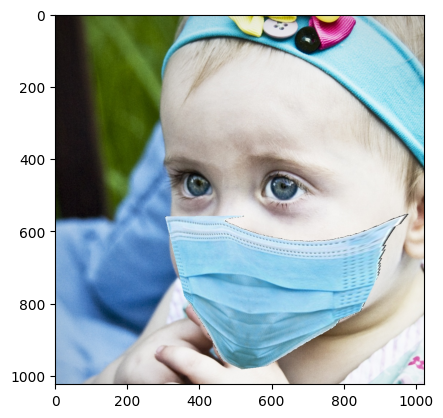

In [68]:
im = cv2.imread(df_mask_train["filename"][0])
label_temp = df_mask_train["label"][0]
print(f"label name : {label_temp}")
im =  cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)

label name : 1


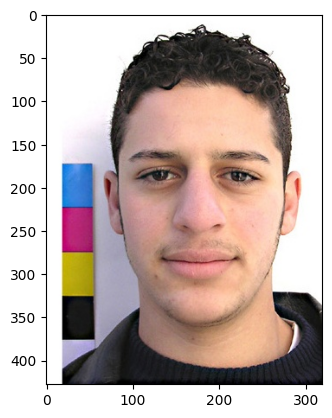

In [69]:
im = cv2.imread(df_no_mask_train["filename"][0])
label_temp = df_no_mask_train["label"][0]
print(f"label name : {label_temp}")
im =  cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)

In [38]:
df_data = pd.concat([df_mask_train, df_no_mask_train], axis=0).sample(frac=1.0,
random_state=1).reset_index(drop=True)
df_data.head()

,filename,label
0,/content/face-mask-dataset/FMD_DATASET/without...,1
1,/content/face-mask-dataset/FMD_DATASET/without...,1
2,/content/face-mask-dataset/FMD_DATASET/without...,1
3,/content/face-mask-dataset/FMD_DATASET/without...,1
4,/content/face-mask-dataset/FMD_DATASET/with_ma...,0


In [72]:
df_data_test = pd.concat([df_mask_test, df_nomask_test], axis=0).sample(frac=1.0,
random_state=1).reset_index(drop=True)
df_data.head()


,filename,label
0,/content/face-mask-dataset/FMD_DATASET/without...,1
1,/content/face-mask-dataset/FMD_DATASET/without...,1
2,/content/face-mask-dataset/FMD_DATASET/without...,1
3,/content/face-mask-dataset/FMD_DATASET/without...,1
4,/content/face-mask-dataset/FMD_DATASET/with_ma...,0


In [15]:
df_data

,filename,label
0,/content/face-mask-dataset/FMD_DATASET/without...,1
1,/content/face-mask-dataset/FMD_DATASET/without...,1
2,/content/face-mask-dataset/FMD_DATASET/without...,1
3,/content/face-mask-dataset/FMD_DATASET/without...,1
4,/content/face-mask-dataset/FMD_DATASET/with_ma...,0
...,...,...
7995,/content/face-mask-dataset/FMD_DATASET/without...,1
7996,/content/face-mask-dataset/FMD_DATASET/without...,1
7997,/content/face-mask-dataset/FMD_DATASET/with_ma...,0
7998,/content/face-mask-dataset/FMD_DATASET/with_ma...,0


In [39]:
df_data["label"].value_counts()


1    4000
0    4000
Name: label, dtype: int64

In [40]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (70% for training and 30% for testing)
train_data, tst_data = train_test_split(df_data, test_size=0.3, shuffle=True, random_state=1)

test_data, val_data = train_test_split(tst_data, test_size=0.5, shuffle=True, random_state=1)


In [19]:
len(train_data)

5600

In [73]:
train_gen = ImageDataGenerator(
      rescale=1./255,
      validation_split=.2,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest'
)

test_gen = ImageDataGenerator(
      rescale=1./255,
)

In [43]:
train_data = train_gen.flow_from_dataframe(
    train_data,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)


Found 4480 validated image filenames belonging to 2 classes.


In [44]:
val_data = test_gen.flow_from_dataframe(
    val_data,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42
)

Found 1200 validated image filenames belonging to 2 classes.


In [74]:
test_data = test_gen.flow_from_dataframe(
    df_data_test,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 840 validated image filenames belonging to 2 classes.


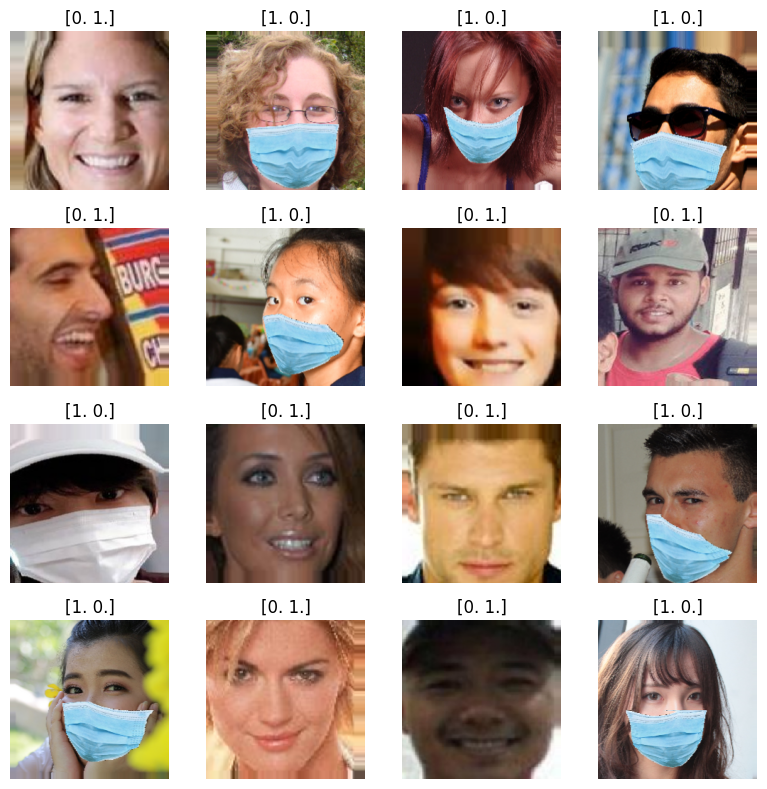

In [46]:
import matplotlib.pyplot as plt

# Get a batch of images from the train_flow generator
imgs, labels = next(train_data)

# Display the images
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8,8))
for i, ax in enumerate(axes.flat):
    ax.imshow(imgs[i])
    ax.axis('off')
    ax.set_title(labels[i])
plt.tight_layout()
plt.show()

In [47]:
es = EarlyStopping(monitor="val_loss",min_delta=0.01,patience=4,verbose=1,mode='min')
mc = ModelCheckpoint(monitor="val_loss",filepath="myyymodel.h5",save_best_only=True,verbose=1,mode='min') 
cd=[es,mc] 


In [48]:
from tensorflow.keras.applications import MobileNet

# Load the MobileNet model without the top layer
mobilenet = MobileNet(include_top=False, input_shape=(224,224,3), weights='imagenet')

# Freeze all the layers in the base model
for layer in mobilenet.layers:
    layer.trainable = False

# Add your custom classifier on top
x = mobilenet.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

# Combine the base MobileNet model with your custom classifier
model = Model(inputs=mobilenet.input, outputs=predictions)

In [49]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                    

In [51]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

In [52]:
history = model.fit(train_data,
                    epochs=10,
                    validation_data=val_data,
                    callbacks=cd)


Epoch 1/10
140/140 [==============================] - ETA: 0s - loss: 0.0244 - accuracy: 0.9908
Epoch 1: val_loss improved from inf to 0.01309, saving model to myyymodel.h5
140/140 [==============================] - 100s 632ms/step - loss: 0.0244 - accuracy: 0.9908 - val_loss: 0.0131 - val_accuracy: 0.9950
Epoch 2/10
140/140 [==============================] - ETA: 0s - loss: 0.0091 - accuracy: 0.9964
Epoch 2: val_loss improved from 0.01309 to 0.00422, saving model to myyymodel.h5
140/140 [==============================] - 87s 624ms/step - loss: 0.0091 - accuracy: 0.9964 - val_loss: 0.0042 - val_accuracy: 0.9983
Epoch 3/10
140/140 [==============================] - ETA: 0s - loss: 0.0034 - accuracy: 0.9991
Epoch 3: val_loss improved from 0.00422 to 0.00269, saving model to myyymodel.h5
140/140 [==============================] - 87s 625ms/step - loss: 0.0034 - accuracy: 0.9991 - val_loss: 0.0027 - val_accuracy: 0.9992
Epoch 4/10
140/140 [==============================] - ETA: 0s - loss: 

In [53]:
f=history.history
print(f.keys())
print(max(f['accuracy']))
print(max(f['val_accuracy']))
print(min(f['loss']))
print(min(f['val_loss']))

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
1.0
0.9991666674613953
0.0005627115024253726
0.0021682889200747013


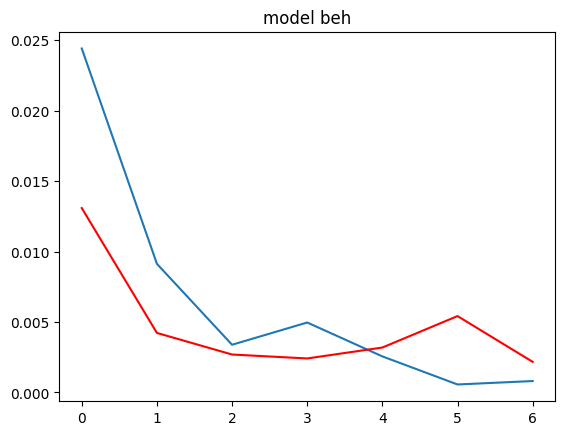

In [54]:
plt.plot(f['loss'])
plt.plot(f['val_loss'],c="red")
plt.title("model beh")
plt.show()

In [55]:
from keras.models import load_model
loaded_model = load_model("/content/myyymodel.h5")

In [75]:
#acc
acc=loaded_model.evaluate_generator(test_data)[1]
print(f"the accuracy is {acc*100} %")

the accuracy is 99.76190328598022 %


In [79]:
from tensorflow.keras.preprocessing import image

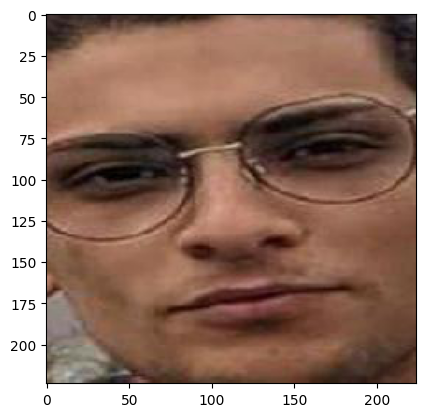

1/1 [==============================] - 0s 29ms/step
no mask
7.436151e-06


In [84]:
# Load the new image
img_path =  "/content/inp.jpg"
img = image.load_img(img_path, target_size=(224, 224))

# Convert the image to an array and normalize it
x = image.img_to_array(img)
x = x / 255.0
plt.imshow(x)
plt.show()
# Reshape the array to match the input shape of your model
x = np.expand_dims(x, axis=0)
# Use your trained model to make predictions
pred = loaded_model.predict(x)[0][0]

if pred > 0.5:
  print("mask")
else:
  print("no mask")
  

  

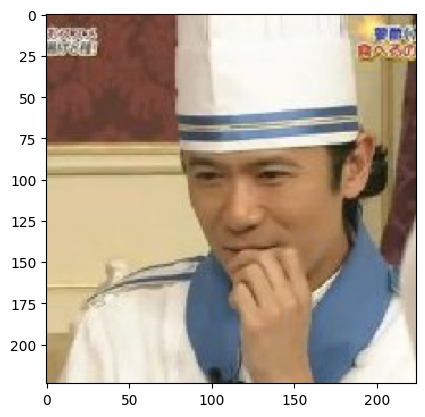

1/1 [==============================] - 0s 31ms/step
no mask


In [85]:
# Load the new image
img_path =  "/content/face-mask-dataset/FMD_DATASET/without_mask/complex/complex114.jpg"
img = image.load_img(img_path, target_size=(224, 224))

# Convert the image to an array and normalize it
x = image.img_to_array(img)
x = x / 255.0
plt.imshow(x)
plt.show()
# Reshape the array to match the input shape of your model
x = np.expand_dims(x, axis=0)
# Use your trained model to make predictions
pred = loaded_model.predict(x)[0][0]

if pred > 0.5:
  print("mask")
else:
  print("no mask")
  

  

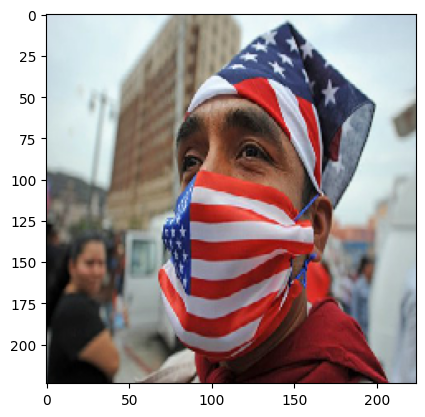

1/1 [==============================] - 0s 32ms/step
mask


In [86]:
# Load the new image
img_path =  "/content/face-mask-dataset/FMD_DATASET/with_mask/complex/complex225.jpg"
img = image.load_img(img_path, target_size=(224, 224))

# Convert the image to an array and normalize it
x = image.img_to_array(img)
x = x / 255.0
plt.imshow(x)
plt.show()
# Reshape the array to match the input shape of your model
x = np.expand_dims(x, axis=0)
# Use your trained model to make predictions
pred = loaded_model.predict(x)[0][0]

if pred > 0.5:
  print("mask")
else:
  print("no mask")
  

  
